----------------------------------------------------------------------------------------------
This notebook was inspired by Nicholas Kern's automatic calibration and imaging pipeline, "casa_imaging_pipeline.py", in CASA for HERA data. This notebook will serve as a breakdown of the four sections, (1) source search and data prep, (2) create model flux source, (3) calibrate data to model, and (4) image the calibrated data. You will also need the scripts called "casa_utils.py" mostly for the purpose of logging information/loading YAML file, and "source2file.py"&"coord_convs.py" (source2file uses coord_convs)  getting output source file for a given ra_source value. This can be found in: 

https://github.com/HERA-Team/casa_imaging/blob/master/casa_imaging/casa_utils.py

https://github.com/HERA-Team/casa_imaging/blob/master/scripts/source2file.py 

https://github.com/HERA-Team/casa_imaging/blob/master/casa_imaging/coord_convs.py .

NOTE: It seems like Nick's scripts were written to only with with miriad files. So I went in and made a few changes to make it more general (eg. source2file.py). This means I can read in any data file using uvd.read(filename, file_type='') as long as I specify the data type. So if you take the scripts directly from github and try to run this notebook, it will break.
    
See skycal_params.yml for relevant parameter selections. https://github.com/HERA-Team/casa_imaging/blob/master/pipelines/skycal_params.yml

The data that was used in this notebook was from /HERA19Golden/RawData/ and I picked zen.2457548.46619.*.HH.uvcRP.uvh5 because it has a JD value of 17h48m04.0538s .

There is another python script called "skycal_pipe.py" and it can be run as 
    skycal_pipe.py -c skycal_params.yaml <options>
----------------------------------------------------------------------------------------------

# I. Search For Source and Prepare Data For MS Conversion 

In [1]:
import numpy as np, healpy as hp, matplotlib.pyplot as plt
import pygsm,time,copy
import pyuvdata.utils as uvutils
import operator,subprocess,argparse
import os,sys,glob,yaml
import json,itertools,shutil

import colorcet as cc
ccc = cc.m_cyclic_grey_15_85_c0_s25
import matplotlib
import cmocean

from astropy.coordinates import EarthLocation
from mpl_toolkits.axes_grid1 import AxesGrid
from astropy.io import fits
from matplotlib import gridspec
from astropy import wcs
from pyuvdata import UVData
from datetime import datetime
from collections import OrderedDict as odict
from astropy.time import Time
from astropy_healpix import HEALPix
from astropy.coordinates import SkyCoord, Galactic
from astropy import units as u
from astropy import constants as c
from copy import deepcopy
from sympy import *
init_printing(use_unicode=True)
from sympy.physics.quantum import TensorProduct

"""
# Works only in python 2 env
sys.path.insert(0,'/Users/tashaleebillings/')
from cst2ijones.jones_matrix_field  import InstrumentalJonesMatrixField
from cst2ijones.plotting import PlotMueller
from cst2ijones import spherical_coordinates_basis_transformation as scbt

sys.path.insert(0,'/Users/tashaleebillings/Desktop/research/plimpy/notebooks/Script Dependencies/')
import source2file # lives in same dir as this notebook
import casa_utils as utils # lives in same dir as this notebook"""

"\n# Works only in python 2 env\nsys.path.insert(0,'/Users/tashaleebillings/')\nfrom cst2ijones.jones_matrix_field  import InstrumentalJonesMatrixField\nfrom cst2ijones.plotting import PlotMueller\nfrom cst2ijones import spherical_coordinates_basis_transformation as scbt\n\nsys.path.insert(0,'/Users/tashaleebillings/Desktop/research/plimpy/notebooks/Script Dependencies/')\nimport source2file # lives in same dir as this notebook\nimport casa_utils as utils # lives in same dir as this notebook"

In [ ]:
%matplotlib notebook

In [8]:
# Define Optional Command-Line Parameters

working_dir = '/Users/tashaleebillings/Desktop/research/working_dir/'
param_file= '/Users/tashaleebillings/Desktop/research/plimpy/scripts/skycal_params.yaml' #Path to a YAML parameter file. See skycal_params.yaml for details.

# Optional Parameters for skycal_pipe.py that, if defined, overwrite their counterpart in skycal_params.yaml
data_root= '/Users/tashaleebillings/Desktop/data/' #Root path to data files: overwrites skycal_params.yaml
data_file= 'zen.2457548.46619.*.HH.uvcRP.uvh5'  #Data file basename zen.2457548.46619.*.HH.uvcRP : overwrites skycal_params.yaml.
                                                # This file was taken from HERA19Golden/RawData/
file_type= 'uvh5' #Specify the file type that you are reading in using pyuvdata. Options are ['uvh5','uvfits','fhd','miriad']"
source= 'Galactic Center' #Source name: overwrites skycal_params.yaml")
source_ra= 232.64 #Source right ascension in J2000 degrees: overwrites skycal_params.yaml
source_dec= -29.0078106 #Source declination in J2000 degrees: overwrites skycal_params.yaml

#### Parse YAML Configuration File 

In [ ]:
# Get config and load dictionary. Nick's script.
cf = utils.load_config(param_file)

In [ ]:
# Consolidate IO, data and analysis parameter dictionaries into tuple pairs (key,value)
# and preserves the order in which the keys are inserted
params = odict(cf['io'].items() + cf['obs'].items() + cf['data'].items() + cf['analysis'].items())
assert len(params) == len(cf['io']) + len(cf['obs']) + len(cf['data']) + len(cf['analysis']), ""\
    "Repeated parameters found within the scope of io, obs, data and analysis dicts"

In [ ]:
# if optional argparser arguments passed, use their values.
# Note: This line of code is slightly different from the script line 64.

params['data_root'] = data_root
params['data_file'] = data_file
params['source'] = source
params['source_ra'] = source_ra
params['source_dec'] = source_dec

In [ ]:
# Get algorithm dictionary
algs = cf['algorithm']
datafile = os.path.join(params['data_root'], params['data_file'])

In [ ]:
# Get parameters used globally in the pipeline
verbose = params['verbose']
overwrite = params['overwrite']
casa = params['casa'].split() + params['casa_flags'].split() # turns value into a list of type str
longitude = params['longitude']
latitude = params['latitude']
out_dir = params['out_dir']
source_ra = params['source_ra']
source_dec = params['source_dec']
source = params['source']

In [ ]:
# Setup (Small) Global Variable Dictionary
varlist = ['datafile', 'verbose', 'overwrite', 'out_dir', 'casa', 'source_ra',
           'source_dec', 'source','longitude', 'latitude', 'lf', 'gaintables']

def global_vars(varlist=[]):
    d = []
    for v in varlist:
        try:
            d.append((v, globals()[v]))
        except KeyError:
            continue
    return dict(d)

In [ ]:
# Print out parameter header
time = datetime.utcnow() #returns current UTC

# This will print log information to the screen but since I didn't specify a working directory
# and the file descriptor to write message to, no log info is saved.
utils.log("Starting skycal_pipe.py on {}\n{}\n".format(time, '-'*60),verbose=verbose)

_cf = copy.copy(cf)
_cf.pop('algorithm')

# This will print log information to the screen but since I didn't specify a working directory
# and the file descriptor to write message to, no log info is saved.
utils.log(json.dumps(_cf, indent=1) + '\n', verbose=verbose) 
# json is text written with JavaScript object notation a syntax for storing and exchanging data.
# If you have a Python object, you can convert it into a JSON string by using the json.dumps() method
utils.log(json.dumps(algs['prep_data'], indent=1)+ '\n', verbose=verbose)

In [ ]:
# Setup a dictionary->object converter
class Dict2Obj:
    def __init__(self, **entries):
        self.__dict__.update(entries)

#### Search for a Source and Prepare Data for MS Conversion 

In [ ]:
4 / (60. * 24 + 4.0)

In [ ]:
if params['prep_data']:
    # start block
    time = datetime.utcnow() #returns current UTC
    utils.log("\n{}\n...Starting PREP_DATA: {}\n".format("-"*60, time),
              verbose=verbose)
    utils.log(json.dumps(algs['prep_data'], indent=1) + '\n', verbose=verbose) #dumps takes an object and produces a string
    p = Dict2Obj(**algs['prep_data'])

    # ---------------------------------
    # Check if datafile is already MS
    # ---------------------------------
    
    #splitext does a reverse search for '.' and returns the extension portion as soon as it finds it
    #instead of doing a forward search for all '' characters and is therefore almost always slower
    if os.path.splitext(datafile)[1] in ['.ms', '.MS']: 
        # get transit time of source
        if source_ra is not None:
            (lst, transit_jd, utc_range, utc_center, source_files,
             source_utc_range) = source2file.source2file(source_ra, filetype=file_type, lon=longitude, lat=latitude,duration=p.duration, start_jd=p.start_jd, get_filetimes=False,verbose=verbose)
            utils.log("...the file {} is already a CASA MS, skipping rest of PREP_DATA".format(datafile), verbose=verbose)
            timerange = utc_range
        else:
            transit_jd = None

    # ---------------------------------
    # For any other datafile
    # ---------------------------------
    
    else:
        # Iterate over polarizations
        if p.pols is None: p.pols = [None]
        uvds = [] # has 4-pol files
        for pol in p.pols:
            if pol is None:
                pol = ''
            else:
                utils.log("...working on {} polarization".format(pol), verbose=verbose)
                pol = '.{}.'.format(pol)
    
            # glob-parse search for datafile template & make a list of files with only that pol (xx then yy and so on)
            # you can build a list data files of the same pol.
            datafiles = [df for df in glob.glob(datafile) if pol in df] 
            assert len(datafiles) > 0, "Searching for {} with pol {} but found no files...".format(datafile, pol)
            
            # get transit times to build proper source file
            if source_ra is not None: #based on source_ra you get a list of relevant files from datafiles, source_files.
                (lst, transit_jd, utc_range, utc_center, source_files,
                 source_utc_range) = source2file.source2file(source_ra, filetype=file_type, lon=longitude, lat=latitude,
                                                             duration=p.duration, start_jd=p.start_jd, get_filetimes=p.get_filetimes,
                                                             verbose=verbose, jd_files=copy.copy(datafiles))
                timerange = utc_range
                                                             
                # ensure source_utc_range and utc_range are similar
                if source_utc_range is not None:
                    utc_range_start = utc_range.split('~')[0].strip('"').split('/')
                    utc_range_start = map(int, utc_range_start[:-1] + utc_range_start[-1].split(':'))
                    utc_range_start = Time(datetime(*utc_range_start), format='datetime').jd
                    source_utc_range_start = source_utc_range.split('~')[0].strip('"').split('/')
                    source_utc_range_start = map(int, source_utc_range_start[:-1] + source_utc_range_start[-1].split(':'))
                    source_utc_range_start = Time(datetime(*source_utc_range_start), format='datetime').jd
                    # if difference is larger than 1 minute,
                    # then probably the correct files were not found
                    if np.abs(utc_range_start - source_utc_range_start) * 24 * 60 > 1:
                        utils.log("Warning: Difference between theoretical transit time and transit time " \
                                                                               "deduced from files found is larger than 1-minute: probably the correct " \
                                                                               "files were not found because the correct files did not exist under the " \
                                                                               "data template {}".format(datafile), verbose=verbose)
                    timerange = source_utc_range
            else:
                source_files = datafiles
        
            # load data into UVData file by file from source_file list to make uvdata list _uvds
            print("Files working with: ",source_files)
            utils.log("...loading data", verbose=verbose)
            _uvds = []
            for sf in list(source_files):
                # read data
                _uvd = UVData()
                _uvd.read(sf, file_type=file_type, antenna_nums=p.antenna_nums)
                
                # read flagfile if fed
                print("Flag Extention",p.flag_ext)
                if p.flag_ext != "":
                    flagfile = glob.glob("{}{}".format(sf, p.flag_ext))
                    if len(flagfile) == 1:
                        utils.log("...loading and applying flags {}".format(flagfile[0]), verbose=verbose)
                        ff = np.load(flagfile[0])
                        _uvd.flag_array += ff['flag_array']
        
                # append to list of files that are of the same pol.
                _uvds.append(_uvd)
            
            # concatenate source files of the same polarization. https://www.geeksforgeeks.org/reduce-in-python/
            uvd = reduce(operator.add, _uvds) #reduce() can also be combined with operator functions to achieve 
                                            #the similar functionality as with lambda functions and makes the 
                                            #code more readable.
            
            #"Data Cutting" Process: isolate only relevant times and cut data into 4-min chunks.
            times = np.unique(uvd.time_array)
            if source_ra is not None:
                transit_jd = np.mean(times) # different from what was calculated using source2file.source2file()
            times = times[np.abs(times - transit_jd) < (p.duration / (24. * 60. * 2))] #sets values to false where ever condition
                                                                                        #is not met so that it preserves the shape
            assert len(times) > 0, "No times found in source_files {} given transit JD {} and duration {}".format(source_files, transit_jd, p.duration)
            uvd.select(times=times) # set data to false/nan (something) for irrelevent times.
                                    # As a result we get a 4 minute file that doesn't match source_utc_range.
            
            # append list that will have 4-pol files [xx,yy,xy,yx].
            uvds.append(uvd)    
        # --------------------------------------------------------------
        # Now we exit the for-loop and move on to the next polarization 
        # --------------------------------------------------------------
        print("uvds are ",uvds)
        # concatenate uvds 4-pol list. Now we have a pyuvdata object with 4-pols.
        uvd = reduce(operator.add, uvds) #reduce() can also be combined with operator functions to achieve 
                                            #the similar functionality as with lambda functions and makes the 
                                            #code more readable.

        # get output filepath w/o uvfits extension if provided
        outfile = os.path.join(params['out_dir'], p.outfile.format(uvd.time_array.min()))
        if os.path.splitext(outfile)[1] == '.uvfits':
            outfile = os.path.splitext(outfile)[0]
        
        # renumber antennas (and antenna names!) if above 254
        if uvd.antenna_numbers.max() > 254:
            large_ant_nums = sorted(list(uvd.antenna_numbers[np.where(uvd.antenna_numbers > 254)[0]]))
            new_nums = sorted(list(set(range(255)) - set(uvd.antenna_numbers)))
            if len(new_nums) < len(large_ant_nums):
                raise ValueError('too many antennas in dataset, cannot renumber all below 255')
            new_nums = new_nums[-1 * len(large_ant_nums):]
            renumber_dict = dict(list(zip(large_ant_nums, new_nums)))
            
            history = ''
            name_prefix = os.path.commonprefix(uvd.antenna_names)
            for ant_in, ant_out in renumber_dict.items():
                if verbose:
                    msg = "renumbering {a1} to {a2}".format(a1=ant_in, a2=ant_out)
                    print(msg)
                history += '{}\n'.format(msg)
                
                wh_ant_num = np.where(uvd.antenna_numbers == ant_in)[0]
                wh_ant1_arr = np.where(uvd.ant_1_array == ant_in)[0]
                wh_ant2_arr = np.where(uvd.ant_2_array == ant_in)[0]
                
                uvd.antenna_numbers[wh_ant_num] = ant_out
                uvd.antenna_names[wh_ant_num[0]] = "RN{:d}".format(ant_out)
                uvd.ant_1_array[wh_ant1_arr] = ant_out
                uvd.ant_2_array[wh_ant2_arr] = ant_out
            
            uvd.baseline_array = uvd.antnums_to_baseline(uvd.ant_1_array, uvd.ant_2_array)
            uvd.history = '{}\n{}'.format(history, uvd.history)
            uvd.check()
            
            # write renumbering dictionary to .npz
            np.savez("{}.renumber.npz".format(outfile),
                     renumber=dict(zip(renumber_dict.values(), renumber_dict.keys())),
                     history="Access dictionary via f['renumber'].item()")
        
        # write to file
        if uvd.phase_type == 'phased':
            # write uvfits
            uvfits_outfile = working_dir + outfile + '.uvfits'
            if not os.path.exists(uvfits_outfile) or overwrite:
                utils.log("...writing {}".format(uvfits_outfile), verbose=verbose)
                uvd.write_uvfits(uvfits_outfile, spoof_nonessential=True)
            # unphase to drift. Undo phasing to try another phase center. He didn't pick a specific phase.
            uvd.unphase_to_drift() 
            # write uvh5
            if not os.path.exists(working_dir + outfile+'.uvh5') or overwrite:
                utils.log("...writing {} to location {}".format(outfile+'.uvh5',working_dir),verbose=verbose)
                uvd.write_uvh5(working_dir + outfile +'.uvh5', clobber=True)
        elif uvd.phase_type == 'drift':
            # write uvh5
            if not os.path.exists(working_dir + outfile+'.uvh5') or overwrite:
                utils.log("...writing {} to location".format(outfile+'.uvh5',working_dir), verbose=verbose)
                uvd.write_uvh5(working_dir + outfile +'.uvh5', clobber=True)
            # write uvfits
            uvfits_outfile = working_dir + outfile + '.uvfits'
            if not os.path.exists(uvfits_outfile) or overwrite:
                uvd.phase_to_time(Time(transit_jd, format='jd'))
                utils.log("...writing {}".format(uvfits_outfile), verbose=verbose)
                uvd.write_uvfits(uvfits_outfile, spoof_nonessential=True)

        # convert the uvfits file to ms
        ms_outfile = working_dir + outfile + '.MS'
        utils.log("...converting to Measurement Set")
        if not os.path.exists(ms_outfile) or overwrite:
            if os.path.exists(ms_outfile):
                shutil.rmtree(ms_outfile)
            utils.log("...writing {}".format(ms_outfile), verbose=verbose)
            ecode = subprocess.check_call(casa + ["-c", "importuvfits('{}', '{}')".format(uvfits_outfile, ms_outfile)])
    
        # overwrite relevant parameters for downstream analysis
        datafile = ms_outfile

        del uvds, uvd

    # overwrite downstream parameters
    algs['gen_model']['time'] = transit_jd

    # end block
    time2 = datetime.utcnow()
    utils.log("...finished PREP_DATA: {:d} sec elapsed".format(utils.get_elapsed_time(time, time2)), verbose=verbose)

#### Going off on a Tangent---> Uncovering The "Data Cutting" Process

In [ ]:
print source_ra, file_type, longitude, latitude, p.duration
print p.start_jd, p.get_filetimes
print verbose, datafiles
print "\n"
print lst, transit_jd, utc_range, utc_center
print source_files,source_utc_range

In [ ]:
ls ../../working_dir/

In [ ]:
# Breakdown of how Nick selects certain times.
uv = UVData()
uv.read(source_files[0], file_type=file_type)
start_jd = 2457548.46619
times = np.unique(uv.time_array)
transit_jd = np.mean(times)

print times
print "\n"
print np.abs(times - transit_jd) < (p.duration / (24. * 60. * 2))
print "\n"
print times[np.abs(times - transit_jd) < (p.duration / (24. * 60. * 2))].max()
print np.where(uv.time_array==start_jd)
print uv.time_array.max()
print uv.time_array.min()

In [ ]:
def calculate_LST(time_in,lon):
    loc = EarthLocation(lat=0*u.deg,lon=lon,height=0*u.m)
    time = Time(time_in,location=loc)
    lst = time.sidereal_time('mean')
    
    return lst

jdcut =2457548.46836791
jd = Time(jdcut,format='jd')
lst = calculate_LST(jd,'21d25m41.0s')
print lst

#### Tangent Ends

# Examine Generated Files

This section will examine the pyuvdata object and CASA measurement set

In [ ]:
uvh5.phase_type

In [ ]:
hdf5file = "../../working_dir/zen.2457548.46837.HH.uvRP.uvh5"
uvfitsfile = "../../working_dir/zen.2457548.46837.HH.uvRP.uvfits"

uvh5 = UVData()
uvh5.read(hdf5file)
#uvfits = UVData()
#uvfits.read(uvfitsfile)

In [ ]:
# Amplitude Visibilities
%matplotlib notebook

ants1 = np.unique(uvh5.ant_1_array)
plt.figure(figsize=(9,8))
for ant in ants1:
    uvh5.select(ant_str='{}x_{}x'.format(ant,ant))
    data = (uvh5.data_array).squeeze()
    plt.plot(data.T.real)
    
    del uvh5
    uvh5 = UVData()
    uvh5.read(hdf5file)

plt.xlabel("Chan [Arb.]")
plt.ylabel("Flux Density [Jy]")
plt.show()

# II. Generate Flux Model

## PYGSM Diffuse Source Model

This section gives a breakdown of how you can use the PYGSM to simulate diffuse. The goal is to build a source model image of the GC over a range of frequencies (100-200 MHz). This will be a Stokes image cube of an unpolarized source.

The next step will be to use Zac's CST to Jones Matrix converter to build the the Meuller Matrix elements over a range of frequencies (100-200 MHz). From there we can take the product of the Meuller Matrix elements and the components of the GSM Stokes Image cube to produce a perceived image model that our data will be calibrated to. 

In [ ]:
# Based on ImageCube_from_PyGSM.py
# Build GSM image cube and save fits image and CASA formatted image

#name of the fits file to take HEADER from. You can use any file
fitsobject = '/Users/tashaleebillings/Desktop/data/mult_spec_1024_chan_gc.2457548.uvcRP.forceQUV2zero.image.fits'
# Build freq. range. You can get this information within any MS file.
f=np.load('/Users/tashaleebillings/Desktop/data/SPECTRAL_WINDOW.npz') #np.linspace(48.8,232.4,1536,endpoint=False) # [MHz]
nchan = f['NUM_CHAN'][0] #(1,)
df = f['CHAN_WIDTH'][0] #(1024,1) was 0.097751711 MHz but now its 97656.25 Hz
freqs = f['CHAN_FREQ']*1e-6 #(1024,1) convert to [MHz] because it's originally in [Hz]

nstokes = 4 # Number of Stokes Parameters
npix = 512

# Load the FITS hdulits
data, header = fits.getdata(fitsobject, header=True)

# Parse the WCS keywords in the primary HDU
w = wcs.WCS(header)

# Create grid and convert to Equatorial Coordinates
lon, lat = np.meshgrid(np.arange(1,npix+1),np.arange(1,npix+1))
ra, dec, dummy_freq, dummy_stokes = w.all_pix2world(lon,lat,1,1,1) #Right ascension and declination as seen on the inside of the celestial sphere
c_icrs = SkyCoord(ra=ra*u.degree, dec=dec*u.degree, frame='icrs') # Coordinates Object

# Transform to Galactic Coordinates
c_galactic = c_icrs.galactic

# Conversion to healpix pixels
nside=512 # for GSM2008 512 for GSM2016 1024
hp_to_cube = hp.ang2pix(nside,np.pi/2.-c_galactic.b.rad,c_galactic.l.rad)

# ----------------------------
#   2008 Version Corrections
# ----------------------------

# Generate Simulation of the sky
cube = np.zeros([nstokes,nchan,npix,npix])
gsm_2008 = pygsm.GlobalSkyModel(freq_unit='MHz', interpolation='pchip', basemap='wmap') #units K*Steradian

for i,freq in enumerate(freqs):
    print i
    print freq
    gsm_2008.generate(freq)
    this_hp_map = gsm_2008.generated_map_data
    this_gc_map = this_hp_map[hp_to_cube]
    cube[0,i,:,:] = this_gc_map
    
"""
# Pick a channel and plot it [Stokes, Freq, RA, Dec]
plt.figure(figsize=(10,10))
plt.imshow(np.log10(cube[0,5,:,:]),aspect='auto')
plt.colorbar()
plt.axis('equal')
plt.xlabel('nPixel')
plt.ylabel('nPixel')
#plt.savefig("")
plt.show()
"""

#PrimaryHDU
hdu = fits.PrimaryHDU(data=cube,header=header)
for k in header.keys():
    if k == '':
        continue
    if k == 'HISTORY':
        continue
    hdu.header.append((k,header[k]))
    
# Important Names for the files    
gsm_model_name_MJyfits = '/Users/tashaleebillings/Desktop/data/GSM2008_Model_of_GC_MJy_1024_WithHeaderCopiedToIt.fits'
gsm_model_name_Jyfits = '/Users/tashaleebillings/Desktop/data/GSM2008_Model_of_GC_Jy_1024_WithHeaderCopiedToIt.fits'
gsm_model_name_Jyimage = '/Users/tashaleebillings/Desktop/data/GSM2008_Model_of_GC_Jy_1024_WithHeaderCopiedToIt.image'

# write new GSM model out to a FITS file
hdu.writeto("{}".format(gsm_model_name_MJyfits),overwrite=True)

# Remember, the flux density is in [MJy] so we need to read in the FITS file and convert it to [Jy]
mjysr = fits.open("{}".format(gsm_model_name_MJyfits))
mjysr[0].data *=1e6
mjysr[0].header['BUNIT']='Jy/pixel' # Change the units
mjysr.writeto("{}".format(gsm_model_name_Jyfits),overwrite=True)

""" 
# Convert FITS file to CASA image file
fits2CASA_command = "casa --nologger --nocrashreport --nogui --agg -c 'importfits('{}', '{}', overwrite=True)'".format(gsm_model_name_Jyfits,gsm_model_name_Jyimage)
os.system(fits2CASA_command)
#/lustre/aoc/projects/hera/tbilling/polim/calibration/old_GSM_Model_of_GC_Jy_1024StokesIQUV_WithHeaderCopiedToIt.fits
TransAxisCASA_command = "casa --nologger --nocrashreport --nogui --agg -c 'imtrans(imagename='{}',outfile='AxisSwap_{}',order ='0132')'".format(gsm_model_name_Jyimage,gsm_model_name_Jyimage)
os.system(TransAxisCASA_command)
"""

In [ ]:
# Pick a channel and plot it [Stokes, Freq, RA, Dec]
plt.figure(figsize=(10,10))
plt.imshow(np.log10(cube[0,5,:,:]),aspect='auto')
plt.colorbar()
plt.axis('equal')
plt.xlabel('nPixel')
plt.ylabel('nPixel')
#plt.savefig("")
plt.show()

#### Check that I can run Zac's CST2JONES.py 

nu0 =  110
Setting interpolant.


/Users/tashaleebillings/anaconda3/envs/hera2/lib/python2.7/site-packages/matplotlib/figure.py:2299: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


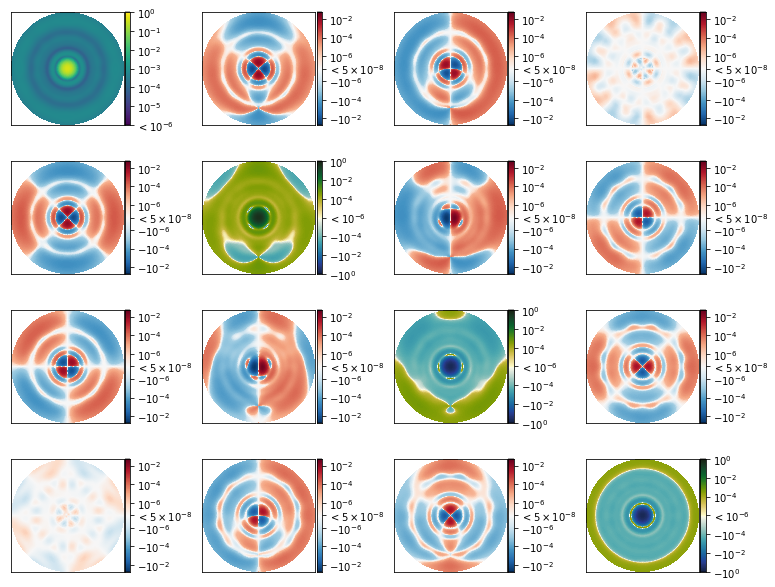

In [2]:
#----------------------------------------------------------------------------------------------
#----------------------------------------------------------------------------------------------
#                                     ZAC'S CST2JONES.PY
#----------------------------------------------------------------------------------------------
#----------------------------------------------------------------------------------------------

#!/bin/sh

#  cst2jones.py
#  
#
#  Created by Zacchary Martinot.
#  

import numpy as np, healpy as hp, matplotlib.pyplot as plt
import os,sys
import colorcet as cc
ccc = cc.m_cyclic_grey_15_85_c0_s25
import matplotlib
import cmocean

from mpl_toolkits.axes_grid1 import AxesGrid
from astropy.io import fits
from astropy import wcs

sys.path.insert(0,'/Users/tashaleebillings/')
from cst2ijones.jones_matrix_field  import InstrumentalJonesMatrixField
from cst2ijones.plotting import PlotMueller
from cst2ijones import spherical_coordinates_basis_transformation as scbt


def txtname(n):
    if n not in range(50,251):
        raise ValueError('no data at that frequency.')
    fname = '/Users/tashaleebillings/Desktop/data/NF_BEAM/HERA_4.9m_E-pattern_ {0}MHz.txt'.format(str(n))
    
    return fname
def StokesMatrix(n):
    if n not in [0,1,2,3]: raise Exception('Input must be an integer in [0,1,2,3]')
    
    if n == 0:
        p = np.array([[1.,0],[0.,1.]])
    elif n == 1:
        p = np.array([[1.,0],[0,-1.]])
    elif n == 2:
        p = np.array([[0,1.],[1.,0]])
    elif n == 3:
        p = np.array([[0., -1j],[1j,0]])
    
    return p

def MuellerMatrixElement(J,i,j):
    
    Pi = StokesMatrix(i)
    Pj = StokesMatrix(j)
    
    M_ij = np.einsum('...ab,...bc,...cd,...ad',Pi,J,Pj,J.conj()) / 2.
    
    M_ij = np.real(M_ij)
    
    return M_ij

def PlotMueller(jones):
    npix = jones.shape[0]
    nside = hp.npix2nside(npix)
    xsize = 1600
    reso = 120*180*np.sqrt(2.)/np.pi /(xsize-1)
    LambProj = hp.projector.AzimuthalProj(xsize=xsize,reso=reso, lamb=True, half_sky=True, rot=[0,30.72])
    p2v = lambda x,y,z: hp.vec2pix(nside,x,y,-z)
    
    logthresh = 4
    linscale = 2
    fig = plt.figure(figsize=(10,10))
    grid = AxesGrid(fig,(1,1,1),
                    nrows_ncols=(4,4),
                    axes_pad=(1.0,0.5),
                    label_mode='all',
                    share_all=False,
                    cbar_location='right',
                    cbar_mode='each',
                    cbar_size='5%',
                    cbar_pad='1%',
                    )
    for i in range(4):
        for j in range(4):
            M_ij = MuellerMatrixElement(jones, i, j)/2.
            img_d = LambProj.projmap(M_ij, p2v)
            
            if i == j == 0:
                cmap = 'viridis'
                vmin = 0
                vmax = 1
                                            
                tick_locs = list(np.linspace(0,1,7, endpoint=True))
                tick_labels = [r'$ < 10^{-6}$',
                               r'$10^{-5}$',
                               r'$10^{-4}$',
                               r'$10^{-3}$',
                               r'$10^{-2}$',
                               r'$10^{-1}$',
                               r'$10^{0}$']
                                                
            elif i != j:
                cmap='RdBu_r'
                vmin=-0.05
                vmax=0.05
                                                                
                d = np.log10(5) * np.diff(np.linspace(vmax*1e-6,vmax,7))[0]
                q = np.linspace(vmax*1e-6,vmax,7)[0::2] - d
                tick_locs = list(np.r_[-np.flipud(q)[:-1],[0], q[1:]])
                tick_labels = [r'$-10^{-2}$',
                               r'$-10^{-4}$',
                               r'$-10^{-6}$',
                               r'$< 5 \times 10^{-8}$',
                               r'$10^{-6}$',
                               r'$10^{-4}$',
                               r'$10^{-2}$']
                                                                    
            else:
                cmap=cmocean.cm.delta
                vmin=-1.
                vmax=1
                                                                                    
                q = np.linspace(vmax*1e-6, vmax,7)[0::2]
                tick_locs = list(np.r_[-np.flipud(q)[:-1],[0], q[1:]])
                tick_labels = [r'$-10^{0}$',
                               r'$-10^{-2}$',
                               r'$-10^{-4}$',
                               r'$< 10^{-6}$',
                               r'$10^{-4}$',
                               r'$10^{-2}$',
                               r'$10^{0}$']
            n = 4 * i + j
            im = grid[n].imshow(img_d, interpolation='none',
                                cmap=cmap,
                                aspect='equal',
                                vmin=vmin,
                                vmax=vmax,)
                                                                                                                
            grid[n].set_xticks([])
            grid[n].set_yticks([])
            
            cbar = grid.cbar_axes[n].colorbar(im, ticks=tick_locs)
            grid.cbar_axes[n].set_yticklabels(tick_labels)
            
            im.set_norm(matplotlib.colors.SymLogNorm(10**-logthresh,linscale, vmin=vmin,vmax=vmax))
        plt.tight_layout(w_pad=0.5, h_pad=1.0)
#     plt.savefig('full_mueller_airy_150MHz.png', dpi=80, bbox_inches='tight')
#     plt.savefig('full_mueller_150MHz.pdf', bbox_inches='tight')
#     plt.close(plt.gcf())
#     plt.show()


for nu0 in range(110,130,20):
    print "nu0 = ", nu0
    nu_nodes = range(nu0-5,nu0+6)
    
    input_files = [txtname(n) for n in nu_nodes]
    
    iJMF = InstrumentalJonesMatrixField(input_files, nu_nodes)
    
    z0_cza = np.radians(120.7215)
    z0 = scbt.r_hat(z0_cza, 0.)
    
    RotAxis = np.array([0,-1,0])
    RotAngle = z0_cza
    
    R_z0 = scbt.rotation_matrix(RotAxis, RotAngle)
    
    nside = 128
    npix = hp.nside2npix(nside)
    hpxidx = np.arange(npix)
    dH, aH = hp.pix2ang(nside, hpxidx)
    thH, phiH = scbt.spherical_coordinates_map(R_z0, dH, aH)
    phiH = 2.*np.pi - phiH
    
    nu_axis = np.linspace(nu0-1.,nu0+1., 3, endpoint=True)
    
    ijones = iJMF(nu_axis, thH, phiH, R_z0.T)
    
    ijones[:,:,:,0] *= -1.
    
    PlotMueller(ijones[1])
    
    # plt.savefig('VivaldiPlots/{}MHz.png'.format(nu0), dpi=80, bbox_inches='tight')
    # plt.savefig('SinuousPlots/{}MHz.png'.format(nu0), dpi=80, bbox_inches='tight')
    plt.savefig('/Users/tashaleebillings/Desktop/research/images/ZacMuellerImage.png')
    #plt.show()
    #plt.close(plt.gcf())

#### Old Version of Making Simulated Interpolated Jones Matrix at 6 frequencies between 145-155 MHz

It might not be correct because something about the way I build my l,m axis

Dim and shape of iJones matrix 5 (6, 512, 512, 2, 2)


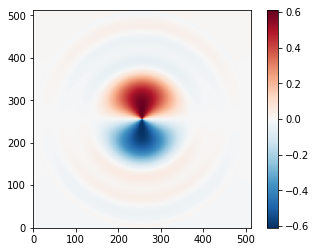

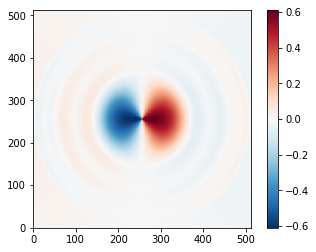

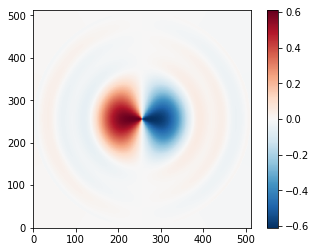

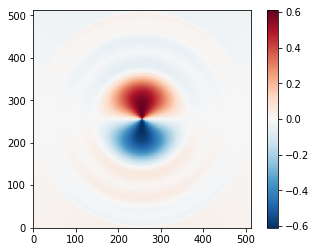

In [3]:
# Modification of Zac's cst2jone_test.py
# You will need Nick Fangnoni's cst files
"""
Build Mueller matrix as a function of frequency from Nick Fangnoni's cst component list 
of Radiation Patterns/E-Field Patterns.
"""

def txtname(n):
    if n not in range(50,251):
        raise ValueError('no data at that frequency.')
    fname = '/Users/tashaleebillings/Desktop/data/NF_BEAM/HERA_4.9m_E-pattern_ {0}MHz.txt'.format(str(n))
    
    return fname

file_freqs = range(145,155) # List of frequencies for each file
input_files = [txtname(n) for n in file_freqs] # List of files at a frequency

# Initializing the direction-dependent Jones matrix for a dipole feed 
J = InstrumentalJonesMatrixField(input_files, file_freqs, use_multiprocessing=False)

# Build Rotation Matrix
z0_cza = np.radians(120.7215)
z0 = scbt.r_hat(z0_cza, 0.) # Join a sequence of arrays along a 0 axis

RotAxis = np.array([0,-1,0]) # rotation along y-axis
RotAngle = z0_cza

R_z0 = scbt.rotation_matrix(RotAxis, RotAngle)

# Frequency Steps to interpolate
df = 0.0977517106549 #MHz
nu_axis = np.array([148.87585533, 148.97360704, 149.07135875,
           149.16911046, 149.26686217, 149.36461388])#np.linspace(149.,151.,6,endpoint=True)
J.set_interpolant(nu_axis)

# Determine the proper theta (rad) and phi (rad) values for a Sky Coordinate 
# value at a specific HealPix pixel value.
pixnum = 512

arcsec = 500.
arcsec2deg = 2#arcsec/3600.

# Build pixel axis
l_axis = np.linspace(-arcsec2deg/2,arcsec2deg/2,pixnum, endpoint=True)# l=cos(phi)sin(theta)
m_axis = np.linspace(-arcsec2deg/2,arcsec2deg/2,pixnum, endpoint=True)# m=sin(phi)sin(theta)

# Create Meshgrid from the pixels to represent equatorial coordinates
ll_grid, mm_grid = np.meshgrid(l_axis, m_axis, indexing='xy')

# Use Trig to express phi and theta as a function of Sky Coordinates
rr2_grid = np.power(ll_grid, 2) + np.power(mm_grid, 2) # = (Sin(theta))**2, limits [0,1]

nn_grid = np.zeros_like(ll_grid) # dim[512,512]=[pixnum,pixnum]
nn_grid[rr2_grid < 1.] = np.sqrt(1. - rr2_grid[rr2_grid < 1.]**2.)# =cos(theta), limits [-1,1]

# don't use ravel because altering the values could change the original data.
nn_flat = nn_grid.flatten()

th_use = np.arccos(nn_flat[nn_flat < 1.])# Theta values, limits [0,np.pi]

phi_grid = np.arctan2(mm_grid, ll_grid)
fix_phi = np.where(phi_grid < 0.)[0]
phi_grid[fix_phi] = 2*np.pi + phi_grid[fix_phi]
phi_grid[nn_grid >= 1.] = np.nan
phi_use = (phi_grid.flatten())[nn_flat < 1.]# Phi values, limits [0, 2*np.pi]

#Interpolate Beam [freq, total Npixels, Row_jones_matrix, Colu_jones_matrix]
R_id = np.eye(3) #Return a 2-D array with ones on the diagonal and zeros elsewhere
ijones = J(nu_axis, th_use, phi_use, R_id)

# reshape jones matrix cube to make an image with dim[freq,pixnum,pixnum, 2x2 jones matrix]
ijones_flat = np.zeros((len(nu_axis),pixnum**2, 2, 2), dtype=np.complex)
ijones_flat[:, nn_flat < 1., :, :] = ijones
# At a certain frequency each pixel has a 2x2 jones matrix
ijones_img = np.reshape(ijones_flat, (len(nu_axis),pixnum, pixnum, 2, 2))
print "Dim and shape of iJones matrix", ijones_img.ndim, ijones_img.shape

plt.figure()
plt.imshow(np.real(ijones_img[2,:,:,0,0].T), origin='lower', cmap='RdBu_r')
plt.colorbar()

plt.figure()
plt.imshow(np.real(ijones_img[2,:,:,0,1].T), origin='lower', cmap='RdBu_r')
plt.colorbar()

plt.figure()
plt.imshow(np.real(ijones_img[2,:,:,1,0].T), origin='lower', cmap='RdBu_r')
plt.colorbar()

plt.figure()
plt.imshow(np.real(ijones_img[2,:,:,1,1].T), origin='lower', cmap='RdBu_r')
plt.colorbar()
plt.show()


In [ ]:
# Mueller Matrix Plots

def StokesMatrix(n):
    if n not in [0,1,2,3]: raise Exception('Input must be an integer in [0,1,2,3]')
    
    if n == 0:
        p = np.array([[1.,0],[0.,1.]])
    elif n == 1:
        p = np.array([[1.,0],[0,-1.]])
    elif n == 2:
        p = np.array([[0,1.],[1.,0]])
    elif n == 3:
        p = np.array([[0., -1j],[1j,0]])
    
    return p

def MuellerMatrixElement(J,i,j):
    
    Pi = StokesMatrix(i) # Pauli Spin Matrix
    Pj = StokesMatrix(j) # Pauli Spin Matrix
    
    M_ij = np.einsum('...ab,...bc,...cd,...ad',Pi,J,Pj,J.conj()) / 2.
    M_ij = np.real(M_ij)
    
    return M_ij

#name of the fits file to take HEADER from. You can use any file
fitsobject = '/Users/tashaleebillings/Desktop/data/gc.2457548.uvcRP.forceQUV2zero_Interactive.image.fits'

# Load the FITS hdulits
data, header = fits.getdata(fitsobject, header=True)

# Generate Simulation of the Mueller Matrix
i_index,j_index = 4,4
nchan = len(nu_axis)
npix = 512
old_version_MuellerMatrixij = np.zeros((i_index,j_index,nchan,npix,npix),dtype=np.float64) # [i,j, freq,ra pixel,dec pixel]

ii_index = [0,0,0,0,1,1,1,1,2,2,2,2,3,3,3,3]
jj_index = [0,1,2,3,0,1,2,3,0,1,2,3,0,1,2,3]

for f in range(nchan):
    for i in range(i_index):
        for j in range(j_index):
           old_version_MuellerMatrixij[i,j,f,:,:] = MuellerMatrixElement(ijones_img[f],i,j)

#PrimaryHDU
hdu = fits.PrimaryHDU(data=old_version_MuellerMatrixij,header=header)
for k in header.keys():
    if k == '':
        continue
    if k == 'HISTORY':
        continue
    hdu.header.append((k,header[k]))

# write new GSM model out to a FITS file
mb_filename='/Users/tashaleebillings/Desktop/data/old_version_MuellerMatrixBeam_148.88_149.36.fits'
hdu.writeto(mb_filename,overwrite=True)
mb = fits.open(mb_filename)
mb[0].header['CTYPE4']='Mueller Components' # Change the name
mb.writeto(mb_filename,overwrite=True)

In [ ]:
iarr = [0,0,0,0,1,1,1,1,2,2,2,2,3,3,3,3]
jarr = [0,1,2,3,0,1,2,3,0,1,2,3,0,1,2,3]

f,axarr = plt.subplots(4,4,sharex=True,sharey=True,figsize=(8,8))
gs = gridspec.GridSpec(4,4)#, wspace=0.01, hspace=0.1)

for i in range(len(iarr)):
    
    ax=plt.subplot(gs[iarr[i],jarr[i]])
    ax.imshow(old_version_MuellerMatrixij[iarr[i],jarr[i],0,:,:])
plt.tight_layout()

f.savefig('/Users/tashaleebillings/Desktop/research/images/MuellerMatrix_oldversion.png')
plt.show()

# New Version: Make Mueller Beam

Use Astropy To Determine Grid and Making Simulated Interpolated Jones Matrix at 6 frequencies between 145-155 MHz

In [4]:
def txtname(n):
    if n not in range(50,251):
        raise ValueError('no data at that frequency.')
    fname = '/Users/tashaleebillings/Desktop/data/NF_BEAM/HERA_4.9m_E-pattern_ {0}MHz.txt'.format(str(n))
    
    return fname
def StokesMatrix(n):
    if n not in [0,1,2,3]: raise Exception('Input must be an integer in [0,1,2,3]')
    
    if n == 0:
        p = np.array([[1.,0],[0.,1.]])
    elif n == 1:
        p = np.array([[1.,0],[0,-1.]])
    elif n == 2:
        p = np.array([[0,1.],[1.,0]])
    elif n == 3:
        p = np.array([[0., -1j],[1j,0]])
    
    return p

def MuellerMatrixElement(J,i,j):
    
    Pi = StokesMatrix(i)
    Pj = StokesMatrix(j)
    
    M_ij = np.einsum('...ab,...bc,...cd,...ad',Pi,J,Pj,J.conj()) / 2.
    
    M_ij = np.real(M_ij)
    
    return M_ij

def image_multiplication(left_image,right_image): #left_image*right_image
    # This function multiplies images together per frequency. 
    #The images should have a shape (row, col, ra_pix, dec_pix). 
    
    result = [[sum(a*b for a,b in zip(left_image_row,right_image_col)) for right_image_col in zip(*right_image)] for left_image_row in left_image]
    result_array = np.array(result)

    return np.array(result_array)

def pbcorrdata(beamdata,modeldata, frequency):
    results = np.zeros((4,512,512))
    freq = frequency

    # iterate through rows of X
    for i in range(len(modeldata)):
       # iterate through columns of Y
       for j in [0]:
           # iterate through rows of Y
           for k in range(len(modeldata)):
               results[i,:,:] += beamdata[i,k,freq,:,:] * modeldata[k,freq,:,:]
    return results

# Build Matrix
i = 1j
i_index,j_index = 4,4
npix = 512

# Initialize Matrix image
# I is the idenity matrix, T converts coherency vector/matrix to Pseudo-Stokes vector/matrix
# S in the conj. inverse of T
I = np.zeros((i_index,j_index,npix,npix),dtype=np.float64) #np.matrix([[1.,0.,0.,0.],[0.,1.,0.,0.],[0.,0.,1.,0.],[0.,0.,0.,1.]])
T = np.zeros((i_index,j_index,npix,npix),dtype=np.complex64) #np.matrix([[1.,0.,0.,1.],[1.,0.,0., -1.],[0.,1.,1., 0.],[0.,-i,i,0.]])
S = np.zeros((i_index,j_index,npix,npix),dtype=np.complex64) #T.inverse # np.matrix([[0.5,0.5,0.,0.],[0.,0.,0.5,0.5*i],[0.,0.,0.5,-0.5*i],[0.5,-0.5,0.,0.]])

# Fill in image
I[0,0,:,:] = 1.
I[1,1,:,:] = 1.
I[2,2,:,:] = 1.
I[3,3,:,:] = 1.

T[0,0,:,:], T[0,3,:,:] = 1., 1.
T[1,0,:,:], T[1,3,:,:] = 1., -1.
T[2,1,:,:], T[2,2,:,:] = 1., 1.
T[3,1,:,:], T[3,2,:,:] = -i, i

S[0,0,:,:], S[0,1,:,:] = 0.5, 0.5
S[1,2,:,:], S[1,3,:,:] = 0.5, 0.5*i
S[2,2,:,:], S[2,3,:,:] = 0.5, -0.5*i
S[3,0,:,:], S[3,1,:,:] = 0.5, -0.5
    

In [5]:
nu0 = 110 #MHz
print "nu0 = ", nu0
nu_nodes = range(nu0-5,nu0+6)

input_files = [txtname(n) for n in nu_nodes]

iJMF = InstrumentalJonesMatrixField(input_files, nu_nodes)

lat = 120.7215
z0_cza = np.radians(lat)
z0 = scbt.r_hat(z0_cza, 0.)

RotAxis = np.array([0,-1,0])
RotAngle = z0_cza

R_z0 = scbt.rotation_matrix(RotAxis, RotAngle)
nu_axis = np.linspace(nu0-1.,nu0+1., 3, endpoint=True)

nu0 =  110


In [6]:
# BUILD PROPER GRID SIZE
# Determine the proper theta (rad) and phi (rad) values for a Sky Coordinate
# value at a specific HealPix pixel value.
npix_sq = 512
fitsobject = "/Users/tashaleebillings/Desktop/data/gc.2457548.uvcRP.forceQUV2zero_Interactive.image.fits"

# Load the FITS hdulits
data, header = fits.getdata(fitsobject, header=True)

# Parse the WCS keywords in the primary HDU
w = wcs.WCS(header)

# Convert Equitorial Coordinates to Spherical Coordinates grid
xpix, ypix = np.meshgrid(np.arange(npix_sq),np.arange(npix_sq), indexing='xy')#np.meshgrid(np.arange(1,npix+1),np.arange(1,npix+1), indexing='xy')
ra, dec, dummy_freq, dummy_stokes = w.all_pix2world(xpix, ypix,1,1,1) #Right ascension and declination as seen on the inside of the celestial sphere
c_icrs = SkyCoord(ra=ra*u.degree, dec=dec*u.degree, frame='icrs') # Coordinates Object

# Convert ra/dec to phi/theta
# don't use ravel because altering the values could change the original data.
theta_grid = np.pi/2. - c_icrs.dec.radian # polar angle limits [0,np.pi]
theta_flat = np.reshape(theta_grid,-1)

#phi_grid = np.radians(header['CRVAL1']) - c_icrs.ra.radian # azimuthal angle limits [0,2*np.pi]
phi_grid = c_icrs.ra.radian.mean() - c_icrs.ra.radian
phi_flat = np.reshape(phi_grid,-1)

# Calculate rotation around -y (?) to get the beam to point at declination = latitude
z0_cza = np.radians(120.7215)
RotAxis = np.array([0,-1,0])
RotAngle = z0_cza
R_z0 = scbt.rotation_matrix(RotAxis, RotAngle)

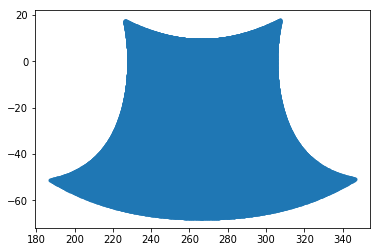

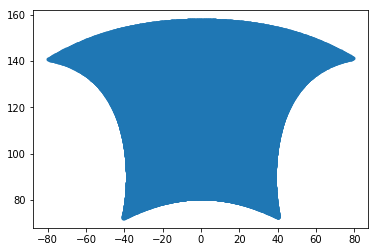

In [7]:
# Check that we have reasonable RA and DEC values
plt.figure()
plt.plot(ra.flatten(),dec.flatten(),'.')
plt.show()

plt.figure()
plt.plot(np.degrees(phi_flat),np.degrees(theta_flat),'.')
plt.show()

In [8]:
# Calculcate the theta, phi corresponding to the original coordinate system

theta_hor, phi_hor = scbt.spherical_coordinates_map(R_z0, theta_flat, phi_flat)
phi_hor = 2.*np.pi - phi_hor
ijones_sq = np.reshape(iJMF(nu_axis, theta_hor, phi_hor, R_z0.T),(len(nu_axis),npix_sq, npix_sq, 2, 2))

Setting interpolant.


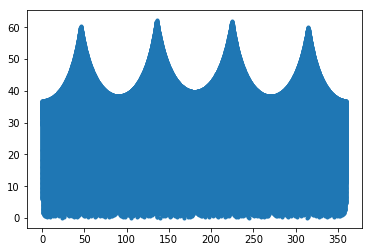

In [9]:
plt.figure()
plt.plot(np.degrees(phi_hor),np.degrees(theta_hor),'.')
plt.show()

In [10]:
def PlotJones(Jones):
    
    plt.figure(figsize=(10,10))
    for i in np.arange(2):
        for j in np.arange(2):
            sp = 2*i + j + 1
            plt.subplot(2,2,sp)
            plt.imshow(np.real(Jones[:,:,i,j]), origin='lower', cmap='RdBu_r')
            plt.axhline(250, color='w', linestyle='--')
            plt.axvline(250, color='w', linestyle='--')
            plt.colorbar()

(3, 512, 512, 2, 2)


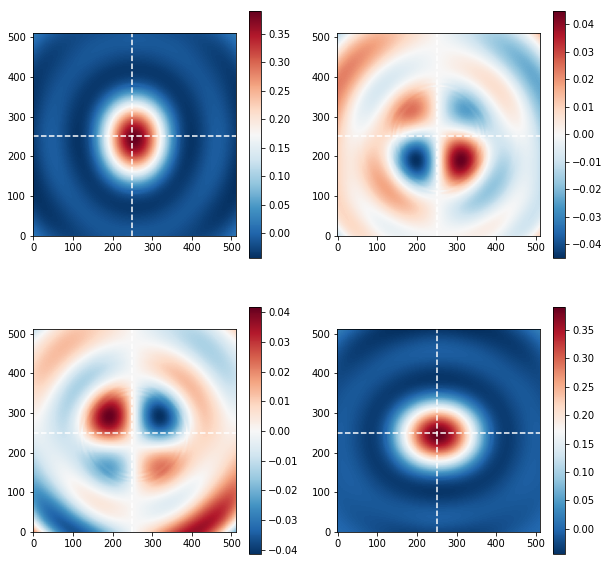

In [11]:
PlotJones(ijones_sq[0])
print ijones_sq.shape

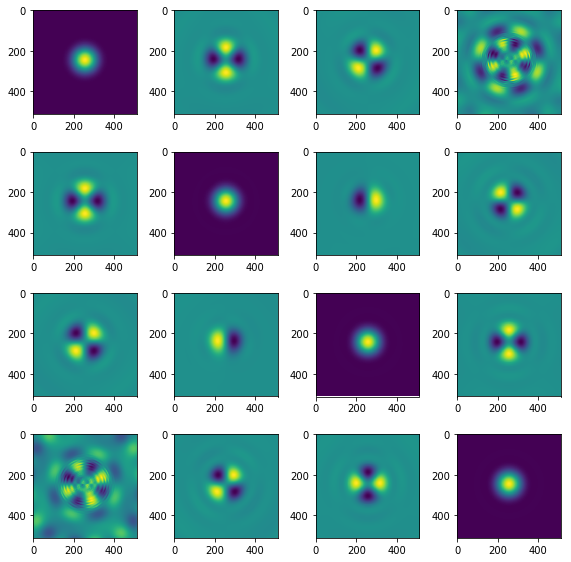

In [12]:
# Generate Simulation of the Mueller Matrix
i_index,j_index = 4,4
nchan = len(nu_axis)
npix = 512
MuellerMatrixij_sq = np.zeros((i_index,j_index,nchan,npix,npix),dtype=np.float64) # [i,j, freq,ra pixel,dec pixel]

#ii_index = [0,0,0,0,1,1,1,1,2,2,2,2,3,3,3,3]
#jj_index = [0,1,2,3,0,1,2,3,0,1,2,3,0,1,2,3]

for f in range(ijones_sq.shape[0]):
    for i in range(i_index):
        for j in range(j_index):
           MuellerMatrixij_sq[i,j,f,:,:] = MuellerMatrixElement(ijones_sq[f],i,j)

#PrimaryHDU
hdu = fits.PrimaryHDU(data=MuellerMatrixij_sq,header=header)
for k in header.keys():
    if k == '':
        continue
    if k == 'HISTORY':
        continue
    hdu.header.append((k,header[k]))

# write new GSM model out to a FITS file
mb_filename='/Users/tashaleebillings/Desktop/data/MuellerMatrixBeam_sq_{}MHz.fits'.format(nu0)
hdu.writeto(mb_filename,overwrite=True)
mb = fits.open(mb_filename)
mb[0].header['CTYPE4']='Mueller Components' # Change the name
mb.writeto(mb_filename,overwrite=True)

iarr = [0,0,0,0,1,1,1,1,2,2,2,2,3,3,3,3]
jarr = [0,1,2,3,0,1,2,3,0,1,2,3,0,1,2,3]

f,axarr = plt.subplots(4,4,sharex=True,sharey=True,figsize=(8,8))
gs = gridspec.GridSpec(4,4)#, wspace=0.01, hspace=0.1)

for i in range(len(iarr)):
    
    ax=plt.subplot(gs[iarr[i],jarr[i]])
    ax.imshow(MuellerMatrixij_sq[iarr[i],jarr[i],0,:,:])
plt.tight_layout()

f.savefig('/Users/tashaleebillings/Desktop/research/images/MuellerMatrix_usingAstropy.png')
plt.show()

#### Pseudo-Stokes Transformation

This section allows you to go from Visibilities to “pseudo-Stokes” representation which refers to Stokes parameters formed from visibilities (pseudo_S_matrix **multiply** mueller_matrix **multiply** S_matrix) or you can keep it as a visibility (Identity_matrix **multiply** mueller_matrix **multiply** S_matrix).

#### Closer look at I, T and S

In this section we will need to verify that all 3 matricies look like they should and that the product of S and T produces the identity matrix.

In [ ]:
"""
i = 1j
i_index,j_index = 4,4
npix = 512

# Initialize Matrix image
# I is the idenity matrix, T converts coherency vector/matrix to Pseudo-Stokes vector/matrix
# S in the conj. inverse of T
I = np.zeros((i_index,j_index,npix,npix),dtype=np.float64) #np.matrix([[1.,0.,0.,0.],[0.,1.,0.,0.],[0.,0.,1.,0.],[0.,0.,0.,1.]])
T = np.zeros((i_index,j_index,npix,npix),dtype=np.complex64) #np.matrix([[1.,0.,0.,1.],[1.,0.,0., -1.],[0.,1.,1., 0.],[0.,-i,i,0.]])
S = np.zeros((i_index,j_index,npix,npix),dtype=np.complex64) #T.inverse # np.matrix([[0.5,0.5,0.,0.],[0.,0.,0.5,0.5*i],[0.,0.,0.5,-0.5*i],[0.5,-0.5,0.,0.]])

# Fill in image
I[0,0,:,:] = 1.
I[1,1,:,:] = 1.
I[2,2,:,:] = 1.
I[3,3,:,:] = 1.

T[0,0,:,:], T[0,3,:,:] = 1., 1.
T[1,0,:,:], T[1,3,:,:] = 1., -1.
T[2,1,:,:], T[2,2,:,:] = 1., 1.
T[3,1,:,:], T[3,2,:,:] = -i, i

S[0,0,:,:], S[0,1,:,:] = 0.5, 0.5
S[1,2,:,:], S[1,3,:,:] = 0.5, 0.5*i
S[2,2,:,:], S[2,3,:,:] = 0.5, -0.5*i
S[3,0,:,:], S[3,1,:,:] = 0.5, -0.5
"""

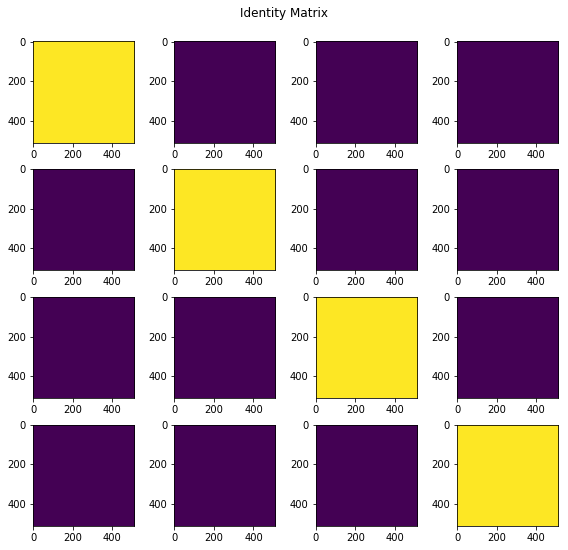

In [13]:
iarr = [0,0,0,0,1,1,1,1,2,2,2,2,3,3,3,3]
jarr = [0,1,2,3,0,1,2,3,0,1,2,3,0,1,2,3]

f,axarr = plt.subplots(4,4,sharex=True,sharey=True,figsize=(8,8))

gs = gridspec.GridSpec(4,4)#, wspace=0.01, hspace=0.1)

for idx in range(len(iarr)):
    
    ax=plt.subplot(gs[iarr[idx],jarr[idx]])
    im=ax.imshow(I[iarr[idx],jarr[idx],:,:],vmin=0,vmax=1)
    
f.suptitle("Identity Matrix")
f.subplots_adjust(top=1.5)
#f.colorbar(im, cax=cax, ax=axarr.ravel().tolist(), orientation="horizontal", pad=0.2)
plt.tight_layout()

plt.show()

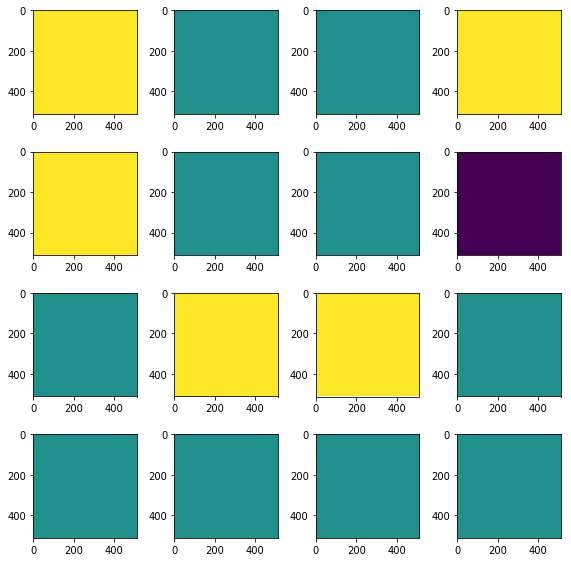

In [14]:
# T MATRIX

iarr = [0,0,0,0,1,1,1,1,2,2,2,2,3,3,3,3]
jarr = [0,1,2,3,0,1,2,3,0,1,2,3,0,1,2,3]

f,axarr = plt.subplots(4,4,sharex=True,sharey=True,figsize=(8,8))
gs = gridspec.GridSpec(4,4)#, wspace=0.01, hspace=0.1)

for idx in range(len(iarr)):
    
    ax=plt.subplot(gs[iarr[idx],jarr[idx]])
    ax.imshow(T[iarr[idx],jarr[idx],:,:].real,vmin=-1,vmax=1)
plt.tight_layout()

plt.show()

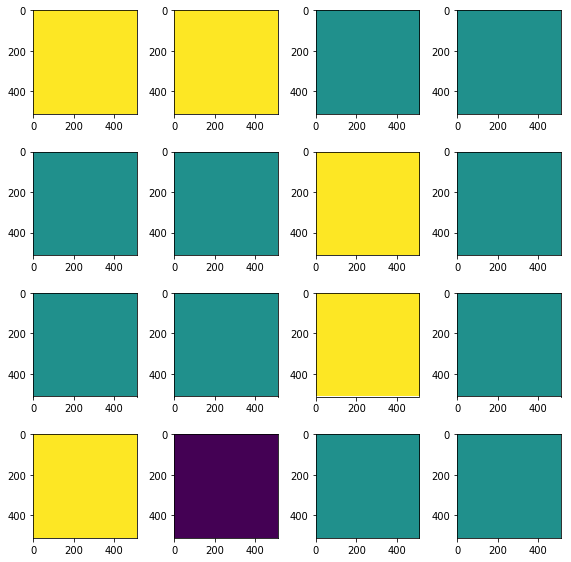

In [15]:
# S MATRIX

iarr = [0,0,0,0,1,1,1,1,2,2,2,2,3,3,3,3]
jarr = [0,1,2,3,0,1,2,3,0,1,2,3,0,1,2,3]

f,axarr = plt.subplots(4,4,sharex=True,sharey=True,figsize=(8,8))
gs = gridspec.GridSpec(4,4)#, wspace=0.01, hspace=0.1)

for idx in range(len(iarr)):
    
    ax=plt.subplot(gs[iarr[idx],jarr[idx]])
    ax.imshow(S[iarr[idx],jarr[idx],:,:].real,vmin=-0.5,vmax=0.5)
plt.tight_layout()

plt.show()

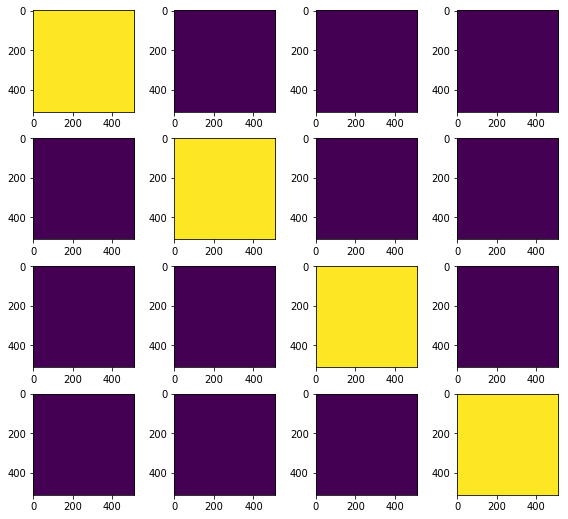

In [16]:
#Does S*T give the identity matrix

identity_m = np.array([[sum(a*b for a,b in zip(S_row,T_col)) for T_col in zip(*T)] for S_row in S]).real

iarr = [0,0,0,0,1,1,1,1,2,2,2,2,3,3,3,3]
jarr = [0,1,2,3,0,1,2,3,0,1,2,3,0,1,2,3]

f,axarr = plt.subplots(4,4,sharex=True,sharey=True,figsize=(8,8))

gs = gridspec.GridSpec(4,4)#, wspace=0.01, hspace=0.1)

for idx in range(len(iarr)):
    
    ax=plt.subplot(gs[iarr[idx],jarr[idx]])
    im=ax.imshow(identity_m[iarr[idx],jarr[idx],:,:],vmin=0,vmax=1.)
    
#f.suptitle("Identity Matrix")
f.subplots_adjust(top=1.5)
#f.colorbar(im, cax=cax, ax=axarr.ravel().tolist(), orientation="horizontal", pad=0.2)
plt.tight_layout()

plt.show()

#### Stokes Mueller Matrix

This section shows this image of the product of Mueller matrix and the coherency_to_stokes conversion matrix MT.

In [17]:
mueller_data = fits.getdata("/Users/tashaleebillings/Desktop/data/MuellerMatrixBeam_sq_148.88_149.36.fits")

In [18]:
print(mueller_data.shape)
print(I.shape)

(4, 4, 3, 512, 512)
(4, 4, 512, 512)


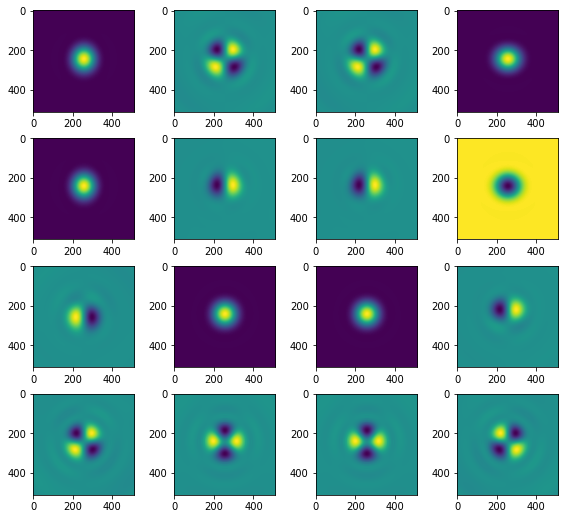

In [19]:
# X*Y = M*T
MT = (np.array(image_multiplication(left_image=mueller_data[:,:,0,:,:],right_image=T))).real

iarr = [0,0,0,0,1,1,1,1,2,2,2,2,3,3,3,3]
jarr = [0,1,2,3,0,1,2,3,0,1,2,3,0,1,2,3]

f,axarr = plt.subplots(4,4,sharex=True,sharey=True,figsize=(8,8))

gs = gridspec.GridSpec(4,4)#, wspace=0.01, hspace=0.1)

for idx in range(len(iarr)):
    
    ax=plt.subplot(gs[iarr[idx],jarr[idx]])
    im=ax.imshow(MT[iarr[idx],jarr[idx],:,:])#,vmin=0,vmax=1.)
    
#f.suptitle("Identity Matrix")
f.subplots_adjust(top=1.5)
#f.colorbar(im, cax=cax, ax=axarr.ravel().tolist(), orientation="horizontal", pad=0.2)
plt.tight_layout()

plt.show()

#### Coherency Mueller Matrix

This section shows this image of the product of S(MT)

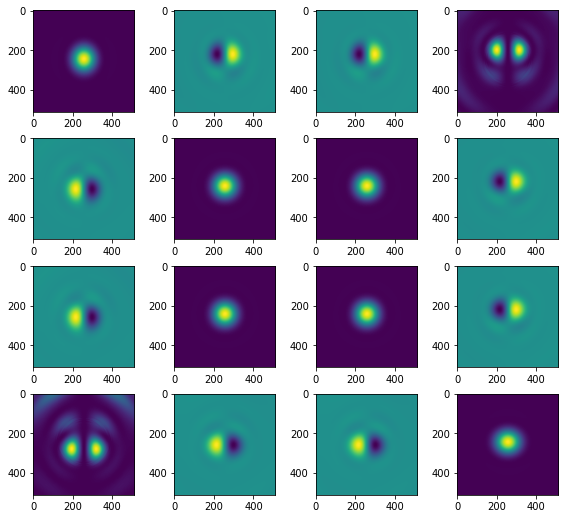

In [25]:
#S*result1
#SMT = (np.array([[sum(a*b for a,b in zip(S_row,result1_col)) for result1_col in zip(*result1)] for S_row in S])).real
SMT = (np.array(image_multiplication(left_image=S,right_image=MT))).real
#SMT=(np.array(result2)).real

iarr = [0,0,0,0,1,1,1,1,2,2,2,2,3,3,3,3]
jarr = [0,1,2,3,0,1,2,3,0,1,2,3,0,1,2,3]

f,axarr = plt.subplots(4,4,sharex=True,sharey=True,figsize=(8,8))

gs = gridspec.GridSpec(4,4)#, wspace=0.01, hspace=0.1)

for idx in range(len(iarr)):
    
    ax=plt.subplot(gs[iarr[idx],jarr[idx]])
    im=ax.imshow(SMT[iarr[idx],jarr[idx],:,:])#,vmin=0,vmax=1.)
    
#f.suptitle("Identity Matrix")
f.subplots_adjust(top=1.5)
#f.colorbar(im, cax=cax, ax=axarr.ravel().tolist(), orientation="horizontal", pad=0.2)
plt.tight_layout()

plt.show()

In [ ]:
(17 + 45*(1/(60)) + 40.0409*(1/(60*60)))/24.*2.*np.pi

#### Get GSM model 

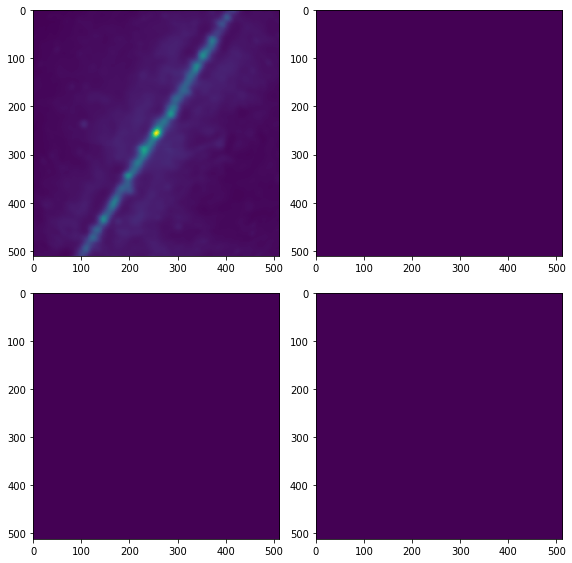

In [21]:
fitsfile = '/Users/tashaleebillings/Desktop/data/GSM2008_Model_of_GC_Jy_1024_WithHeaderCopiedToIt.fits'
fdata,fheader = fits.getdata(fitsfile,header=True)

#fdata[2,:,:,:] *=0
iarr = [0,0,1,1]
jarr = [0,1,0,1]

f,axarr = plt.subplots(2,2,sharex=True,sharey=True,figsize=(8,8))
gs = gridspec.GridSpec(2,2)#, wspace=0.01, hspace=0.1)

for i in range(len(iarr)):   
    ax=plt.subplot(gs[iarr[i],jarr[i]])
    ax.imshow(fdata[i,0,:,:])
    
plt.tight_layout()

plt.show()

#### PB Correct Model

This is a pbcorr model without accounting for T or S.

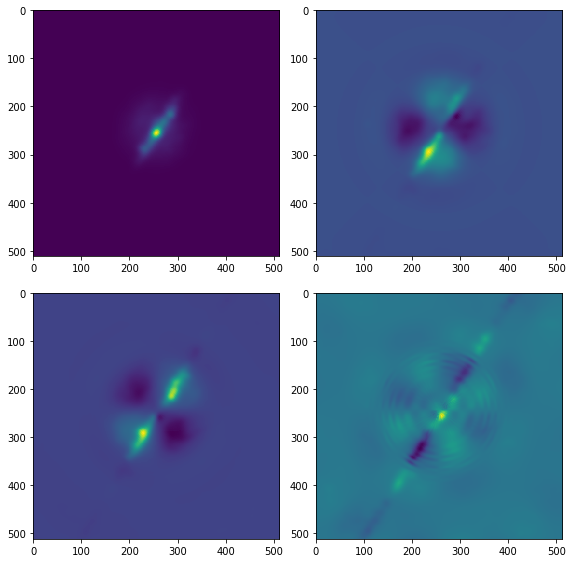

In [22]:
beamfitsfile = '/Users/tashaleebillings/Desktop/data/MuellerMatrixBeam_sq_110MHz.fits'
bdata,bheader = fits.getdata(beamfitsfile,header=True)


iarr = [0,0,1,1]
jarr = [0,1,0,1]

f,axarr = plt.subplots(2,2,sharex=True,sharey=True,figsize=(8,8))
gs = gridspec.GridSpec(2,2)#, wspace=0.01, hspace=0.1)

for ii in range(len(iarr)):    
    ax=plt.subplot(gs[iarr[ii],jarr[ii]])
    ax.imshow(pbcorrdata(beamdata=bdata,modeldata=fdata, frequency=0)[ii,:,:])
    
plt.tight_layout()

#f.savefig('/Users/tashaleebillings/Desktop/research/images/.png')
plt.show()


#### PB Correction

This model is pbcorr using a beam coherency -> S(MT)

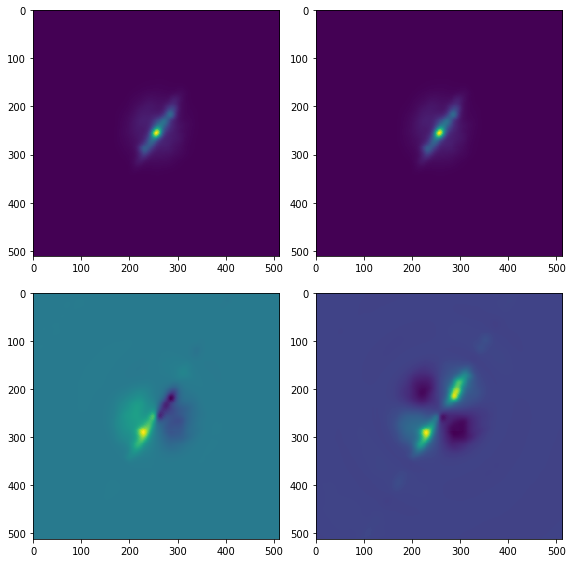

In [23]:
pbcoor_MT = np.zeros((4,512,512))
freq = 0
beamdata = MT
modeldata = fdata

# iterate through rows of X
for i in range(len(modeldata)):
   # iterate through columns of Y
   for j in [0]:
       # iterate through rows of Y
       for k in range(len(modeldata)):
           pbcoor_MT[i,:,:] += beamdata[i,k,:,:] * modeldata[k,freq,:,:]

iarr = [0,0,1,1]
jarr = [0,1,0,1]

f,axarr = plt.subplots(2,2,sharex=True,sharey=True,figsize=(8,8))
gs = gridspec.GridSpec(2,2)#, wspace=0.01, hspace=0.1)

for ii in range(len(iarr)):    
    ax=plt.subplot(gs[iarr[ii],jarr[ii]])
    ax.imshow(pbcoor_MT[ii,:,:])
    
plt.tight_layout()

#f.savefig('/Users/tashaleebillings/Desktop/research/images/.png')
plt.show()


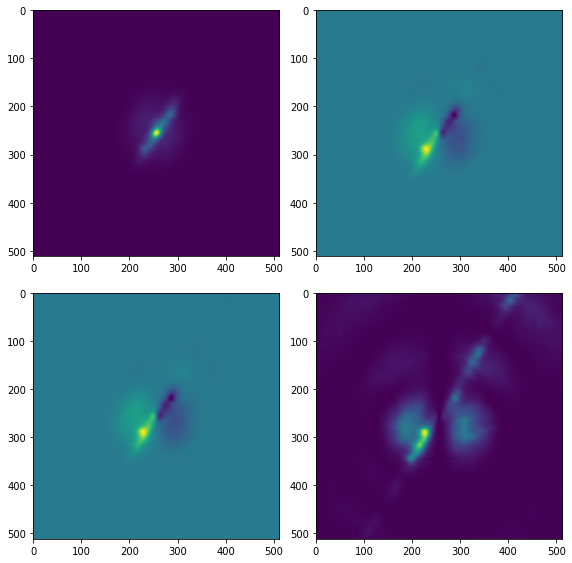

In [26]:
pbcorr_SMT = np.zeros((4,512,512))
freq = 0
beamdata = SMT
modeldata = fdata

# iterate through rows of X
for i in range(len(modeldata)):
   # iterate through columns of Y
   for j in [0]:
       # iterate through rows of Y
       for k in range(len(modeldata)):
           pbcorr_SMT[i,:,:] += beamdata[i,k,:,:] * modeldata[k,freq,:,:]

iarr = [0,0,1,1]
jarr = [0,1,0,1]

f,axarr = plt.subplots(2,2,sharex=True,sharey=True,figsize=(8,8))
gs = gridspec.GridSpec(2,2)#, wspace=0.01, hspace=0.1)

for ii in range(len(iarr)):    
    ax=plt.subplot(gs[iarr[ii],jarr[ii]])
    ax.imshow(pbcorr_SMT[ii,:,:])
    
plt.tight_layout()

#f.savefig('/Users/tashaleebillings/Desktop/research/images/.png')
plt.show()


## GLEAM Point Source Model

Nick uses his scirpt, "complist_gleam.py", to generate an image cube. This can be found: 

https://github.com/HERA-Team/casa_imaging/blob/master/scripts/complist_gleam.py